### Data Dictionary

Imagine a telecommunications provider has segmented its customer base by service usage patterns, categorizing the customers into four groups. If demographic data can be used to predict group membership, the company can customize offers for individual prospective customers. It is a classification problem. That is, given the dataset,  with predefined labels, we need to build a model to be used to predict class of a new or unknown case. 

The example focuses on using demographic data, such as region, age, and marital, to predict usage patterns. 

The target field, called __custcat__, has four possible values that correspond to the four customer groups, as follows:
  1- Basic Service
  2- E-Service
  3- Plus Service
  4- Total Service

Our objective is to build a classifier, to predict the class of unknown cases.

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance

%matplotlib inline
sns.set_style('dark')
sns.set(font_scale=1.5)

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score
from sklearn.metrics import auc, f1_score, precision_score, recall_score, roc_auc_score


import feature_engine.missing_data_imputers as mdi
from feature_engine.outlier_removers import Winsorizer

from tpot import TPOTClassifier, TPOTRegressor

import warnings
warnings.filterwarnings('ignore')

import pickle
from pickle import dump

from imblearn.over_sampling import SMOTE 

pd.options.display.max_columns= None
#pd.options.display.max_rows = None

Using TensorFlow backend.


### Data Exploration

In [2]:
df = pd.read_csv("teleCust1000t.csv")

In [3]:
df

,region,tenure,age,marital,address,income,ed,employ,retire,gender,reside,custcat
0,2,13,44,1,9,64.0,4,5,0.0,0,2,1
1,3,11,33,1,7,136.0,5,5,0.0,0,6,4
2,3,68,52,1,24,116.0,1,29,0.0,1,2,3
3,2,33,33,0,12,33.0,2,0,0.0,1,1,1
4,2,23,30,1,9,30.0,1,2,0.0,0,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,10,39,0,0,27.0,3,0,0.0,1,3,1
996,1,7,34,0,2,22.0,5,5,0.0,1,1,1
997,3,67,59,0,40,944.0,5,33,0.0,1,1,4
998,3,70,49,0,18,87.0,2,22,0.0,1,1,3


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   region   1000 non-null   int64  
 1   tenure   1000 non-null   int64  
 2   age      1000 non-null   int64  
 3   marital  1000 non-null   int64  
 4   address  1000 non-null   int64  
 5   income   1000 non-null   float64
 6   ed       1000 non-null   int64  
 7   employ   1000 non-null   int64  
 8   retire   1000 non-null   float64
 9   gender   1000 non-null   int64  
 10  reside   1000 non-null   int64  
 11  custcat  1000 non-null   int64  
dtypes: float64(2), int64(10)
memory usage: 93.9 KB


In [5]:
df.describe(include='all')

,region,tenure,age,marital,address,income,ed,employ,retire,gender,reside,custcat
count,1000.0000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.0220,35.526000,41.684000,0.495000,11.551000,77.535000,2.671000,10.987000,0.047000,0.517000,2.331000,2.487000
std,0.8162,21.359812,12.558816,0.500225,10.086681,107.044165,1.222397,10.082087,0.211745,0.499961,1.435793,1.120306
min,1.0000,1.000000,18.000000,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,1.0000,17.000000,32.000000,0.000000,3.000000,29.000000,2.000000,3.000000,0.000000,0.000000,1.000000,1.000000
50%,2.0000,34.000000,40.000000,0.000000,9.000000,47.000000,3.000000,8.000000,0.000000,1.000000,2.000000,3.000000
75%,3.0000,54.000000,51.000000,1.000000,18.000000,83.000000,4.000000,17.000000,0.000000,1.000000,3.000000,3.000000
max,3.0000,72.000000,77.000000,1.000000,55.000000,1668.000000,5.000000,47.000000,1.000000,1.000000,8.000000,4.000000


In [6]:
df.shape

(1000, 12)

In [7]:
df.columns

Index(['region', 'tenure', 'age', 'marital', 'address', 'income', 'ed',
       'employ', 'retire', 'gender', 'reside', 'custcat'],
      dtype='object')

### Data Visualization

### Univariate Data Exploration

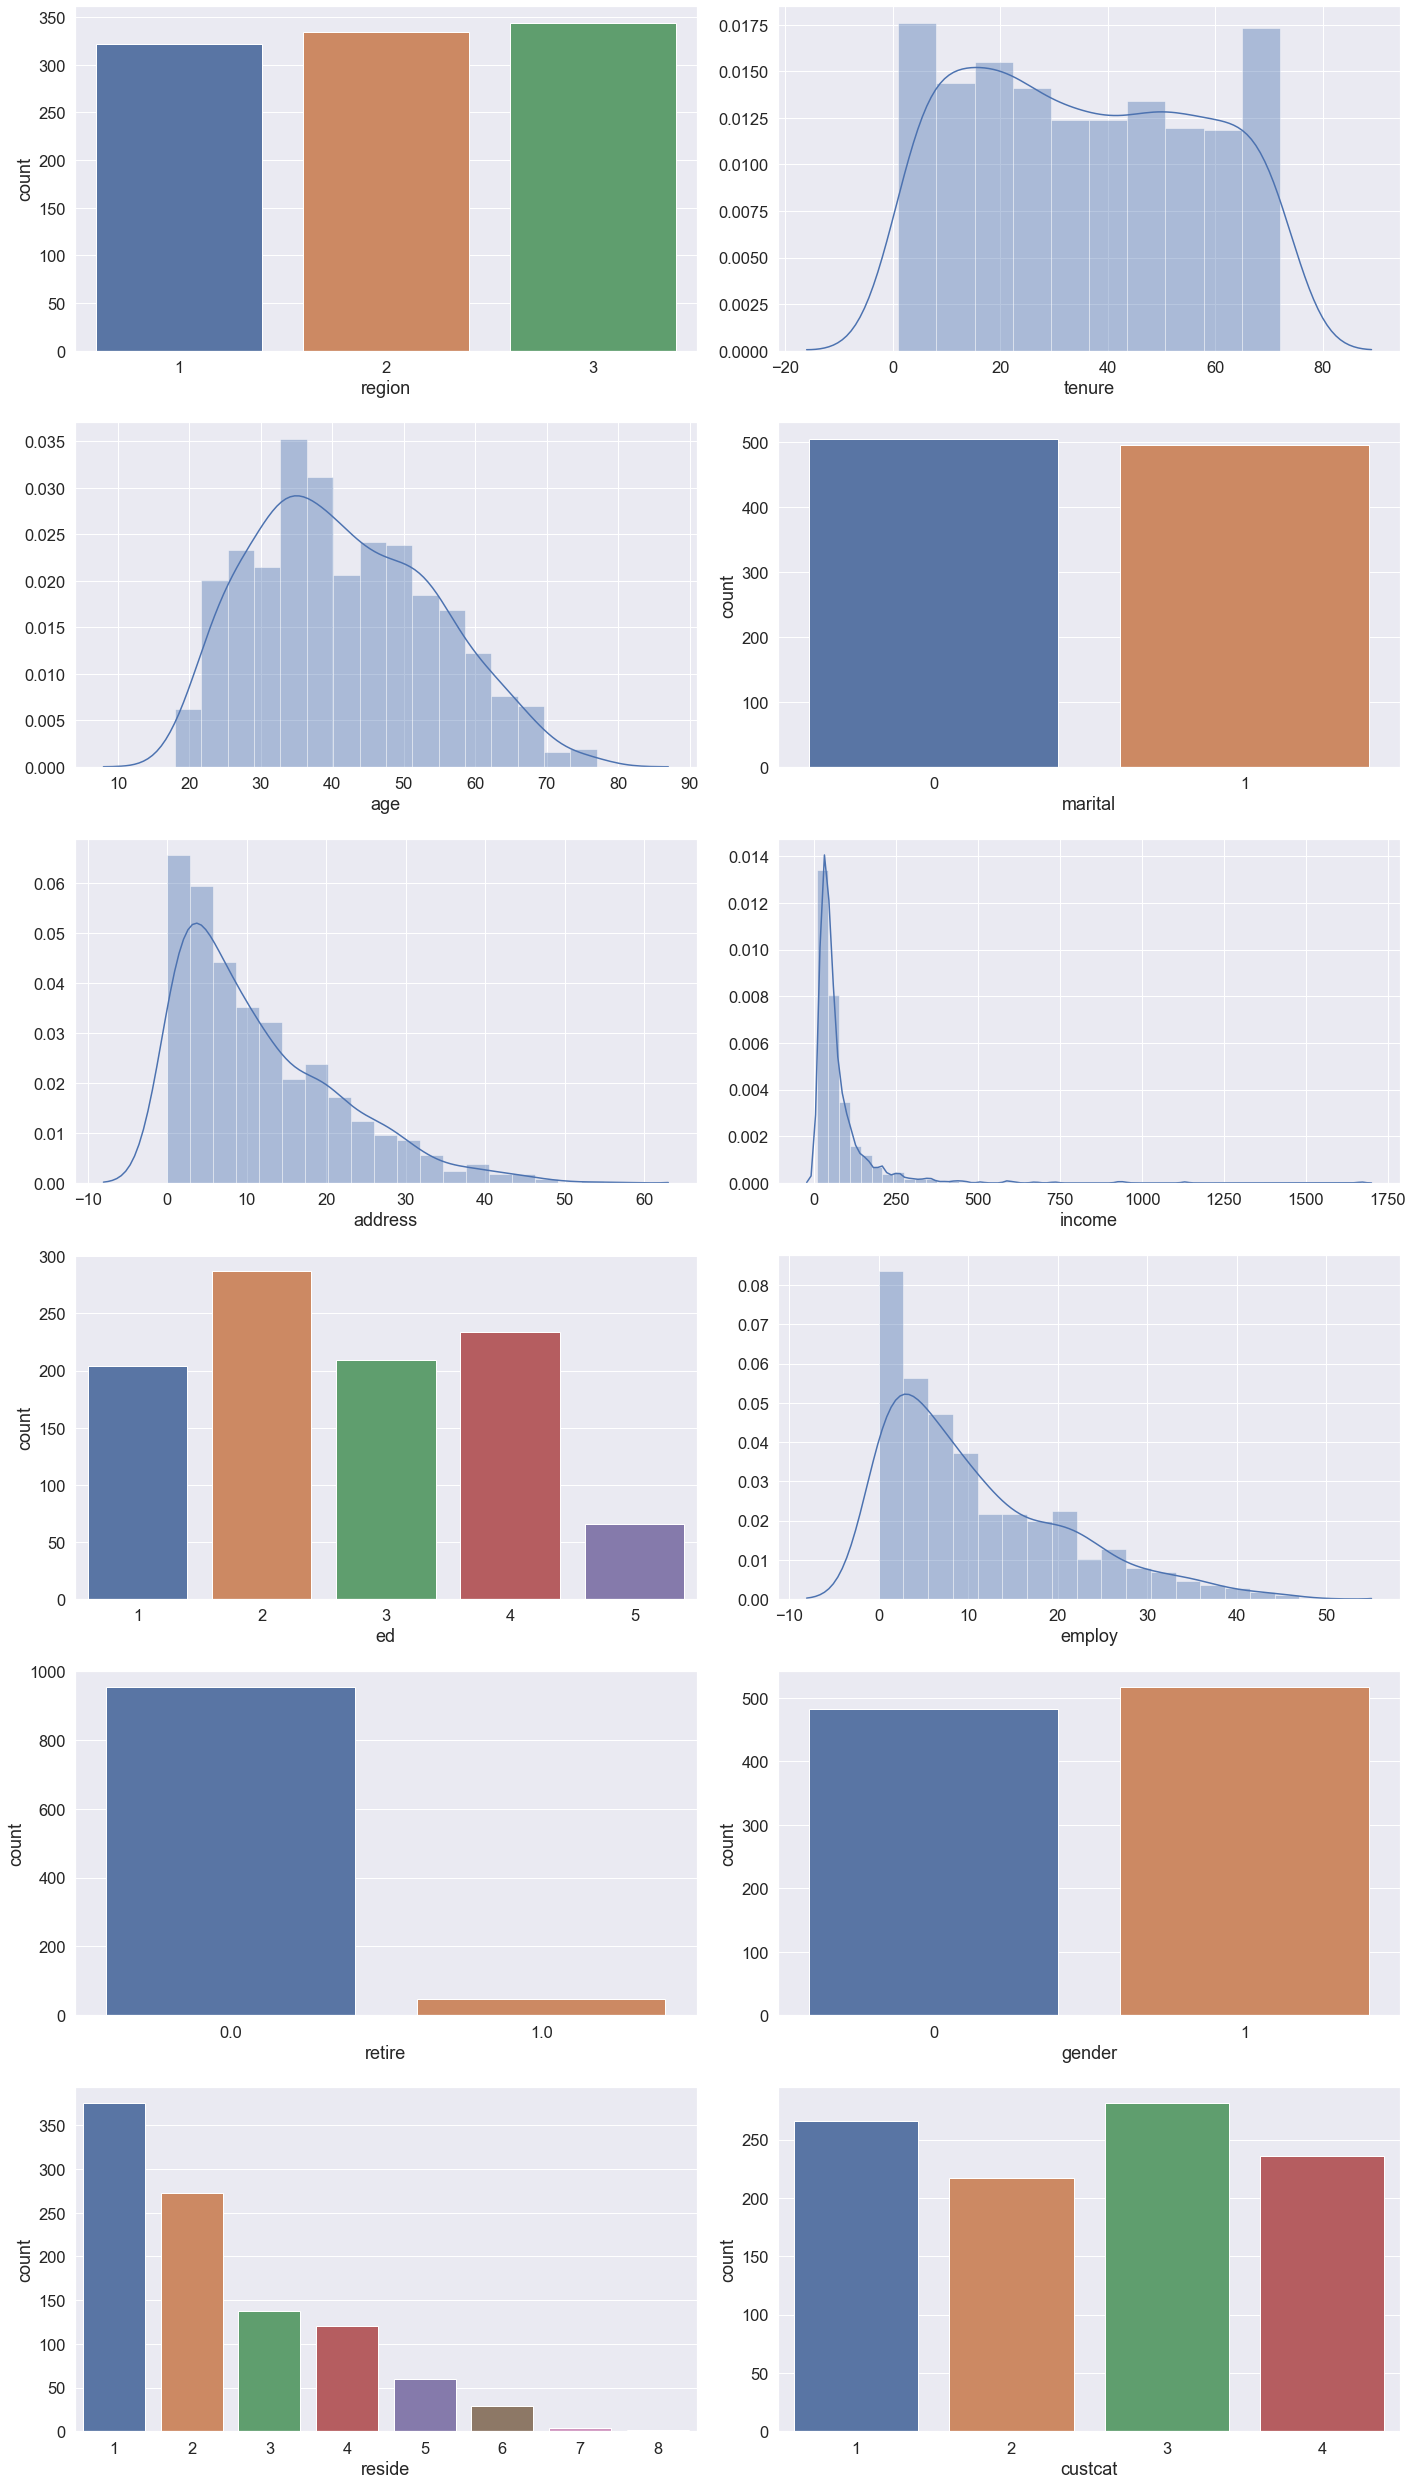

In [8]:
fig = plt.figure(figsize=(20,40))

plt.subplot(7,2,1)
sns.countplot(df.region)
plt.subplot(7,2,2)
sns.distplot(df.tenure)
plt.subplot(7,2,3)
sns.distplot(df.age)
plt.subplot(7,2,4)
sns.countplot(df.marital)
plt.subplot(7,2,5)
sns.distplot(df.address)
plt.subplot(7,2,6)
sns.distplot(df.income)
plt.subplot(7,2,7)
sns.countplot(df.ed)
plt.subplot(7,2,8)
sns.distplot(df.employ)
plt.subplot(7,2,9)
sns.countplot(df.retire)
plt.subplot(7,2,10)
sns.countplot(df.gender)
plt.subplot(7,2,11)
sns.countplot(df.reside)
plt.subplot(7,2,12)
sns.countplot(df.custcat)
# plt.subplot(7,2,13)
# sns.countplot()
# plt.subplot(7,2,14)
# sns.countplot()

plt.tight_layout()
plt.show()

### Bivariate Data Exploration

In [9]:
df.corr()

,region,tenure,age,marital,address,income,ed,employ,retire,gender,reside,custcat
region,1.000000,0.016388,0.015034,-0.080637,0.010320,0.023765,-0.057952,0.016335,0.005595,0.050596,-0.065158,-0.023771
tenure,0.016388,1.000000,0.490217,0.154171,0.522952,0.242912,-0.109797,0.520288,0.171143,0.023533,-0.036592,0.166691
age,0.015034,0.490217,1.000000,-0.014433,0.660435,0.327948,-0.154857,0.670047,0.429440,-0.011419,-0.254993,0.056909
marital,-0.080637,0.154171,-0.014433,1.000000,-0.012051,-0.043984,0.001400,-0.002891,-0.078109,0.008345,0.625999,0.083836
address,0.010320,0.522952,0.660435,-0.012051,1.000000,0.226781,-0.128330,0.463291,0.292503,0.008363,-0.201645,0.067913
income,0.023765,0.242912,0.327948,-0.043984,0.226781,1.000000,0.113939,0.516349,-0.083651,0.038706,-0.097591,0.134525
ed,-0.057952,-0.109797,-0.154857,0.001400,-0.128330,0.113939,1.000000,-0.228580,-0.114229,0.006704,0.021045,0.193864
employ,0.016335,0.520288,0.670047,-0.002891,0.463291,0.516349,-0.228580,1.000000,0.277401,0.046016,-0.134683,0.110011
retire,0.005595,0.171143,0.429440,-0.078109,0.292503,-0.083651,-0.114229,0.277401,1.000000,0.053906,-0.140120,0.008908
gender,0.050596,0.023533,-0.011419,0.008345,0.008363,0.038706,0.006704,0.046016,0.053906,1.000000,0.016556,-0.004966


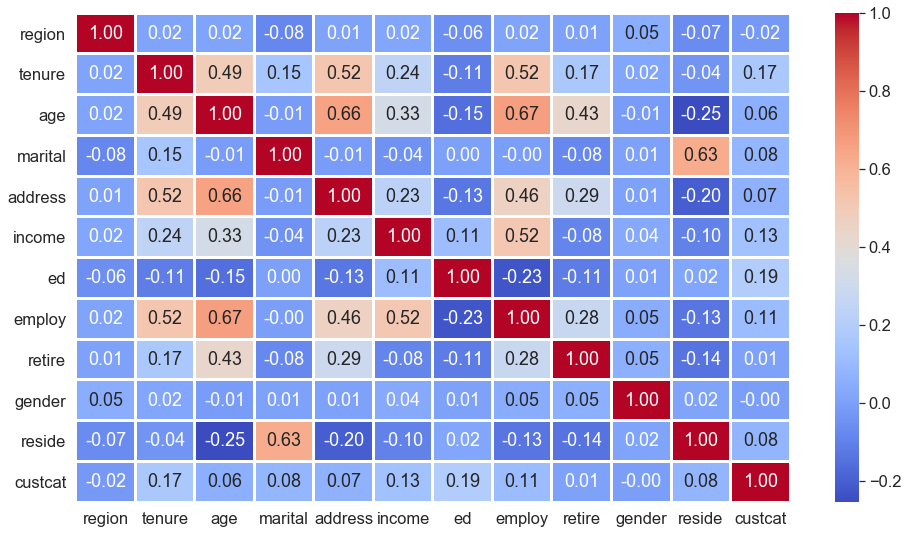

In [10]:
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(),cmap="coolwarm",annot=True,fmt='.2f',linewidths=2)
plt.show()

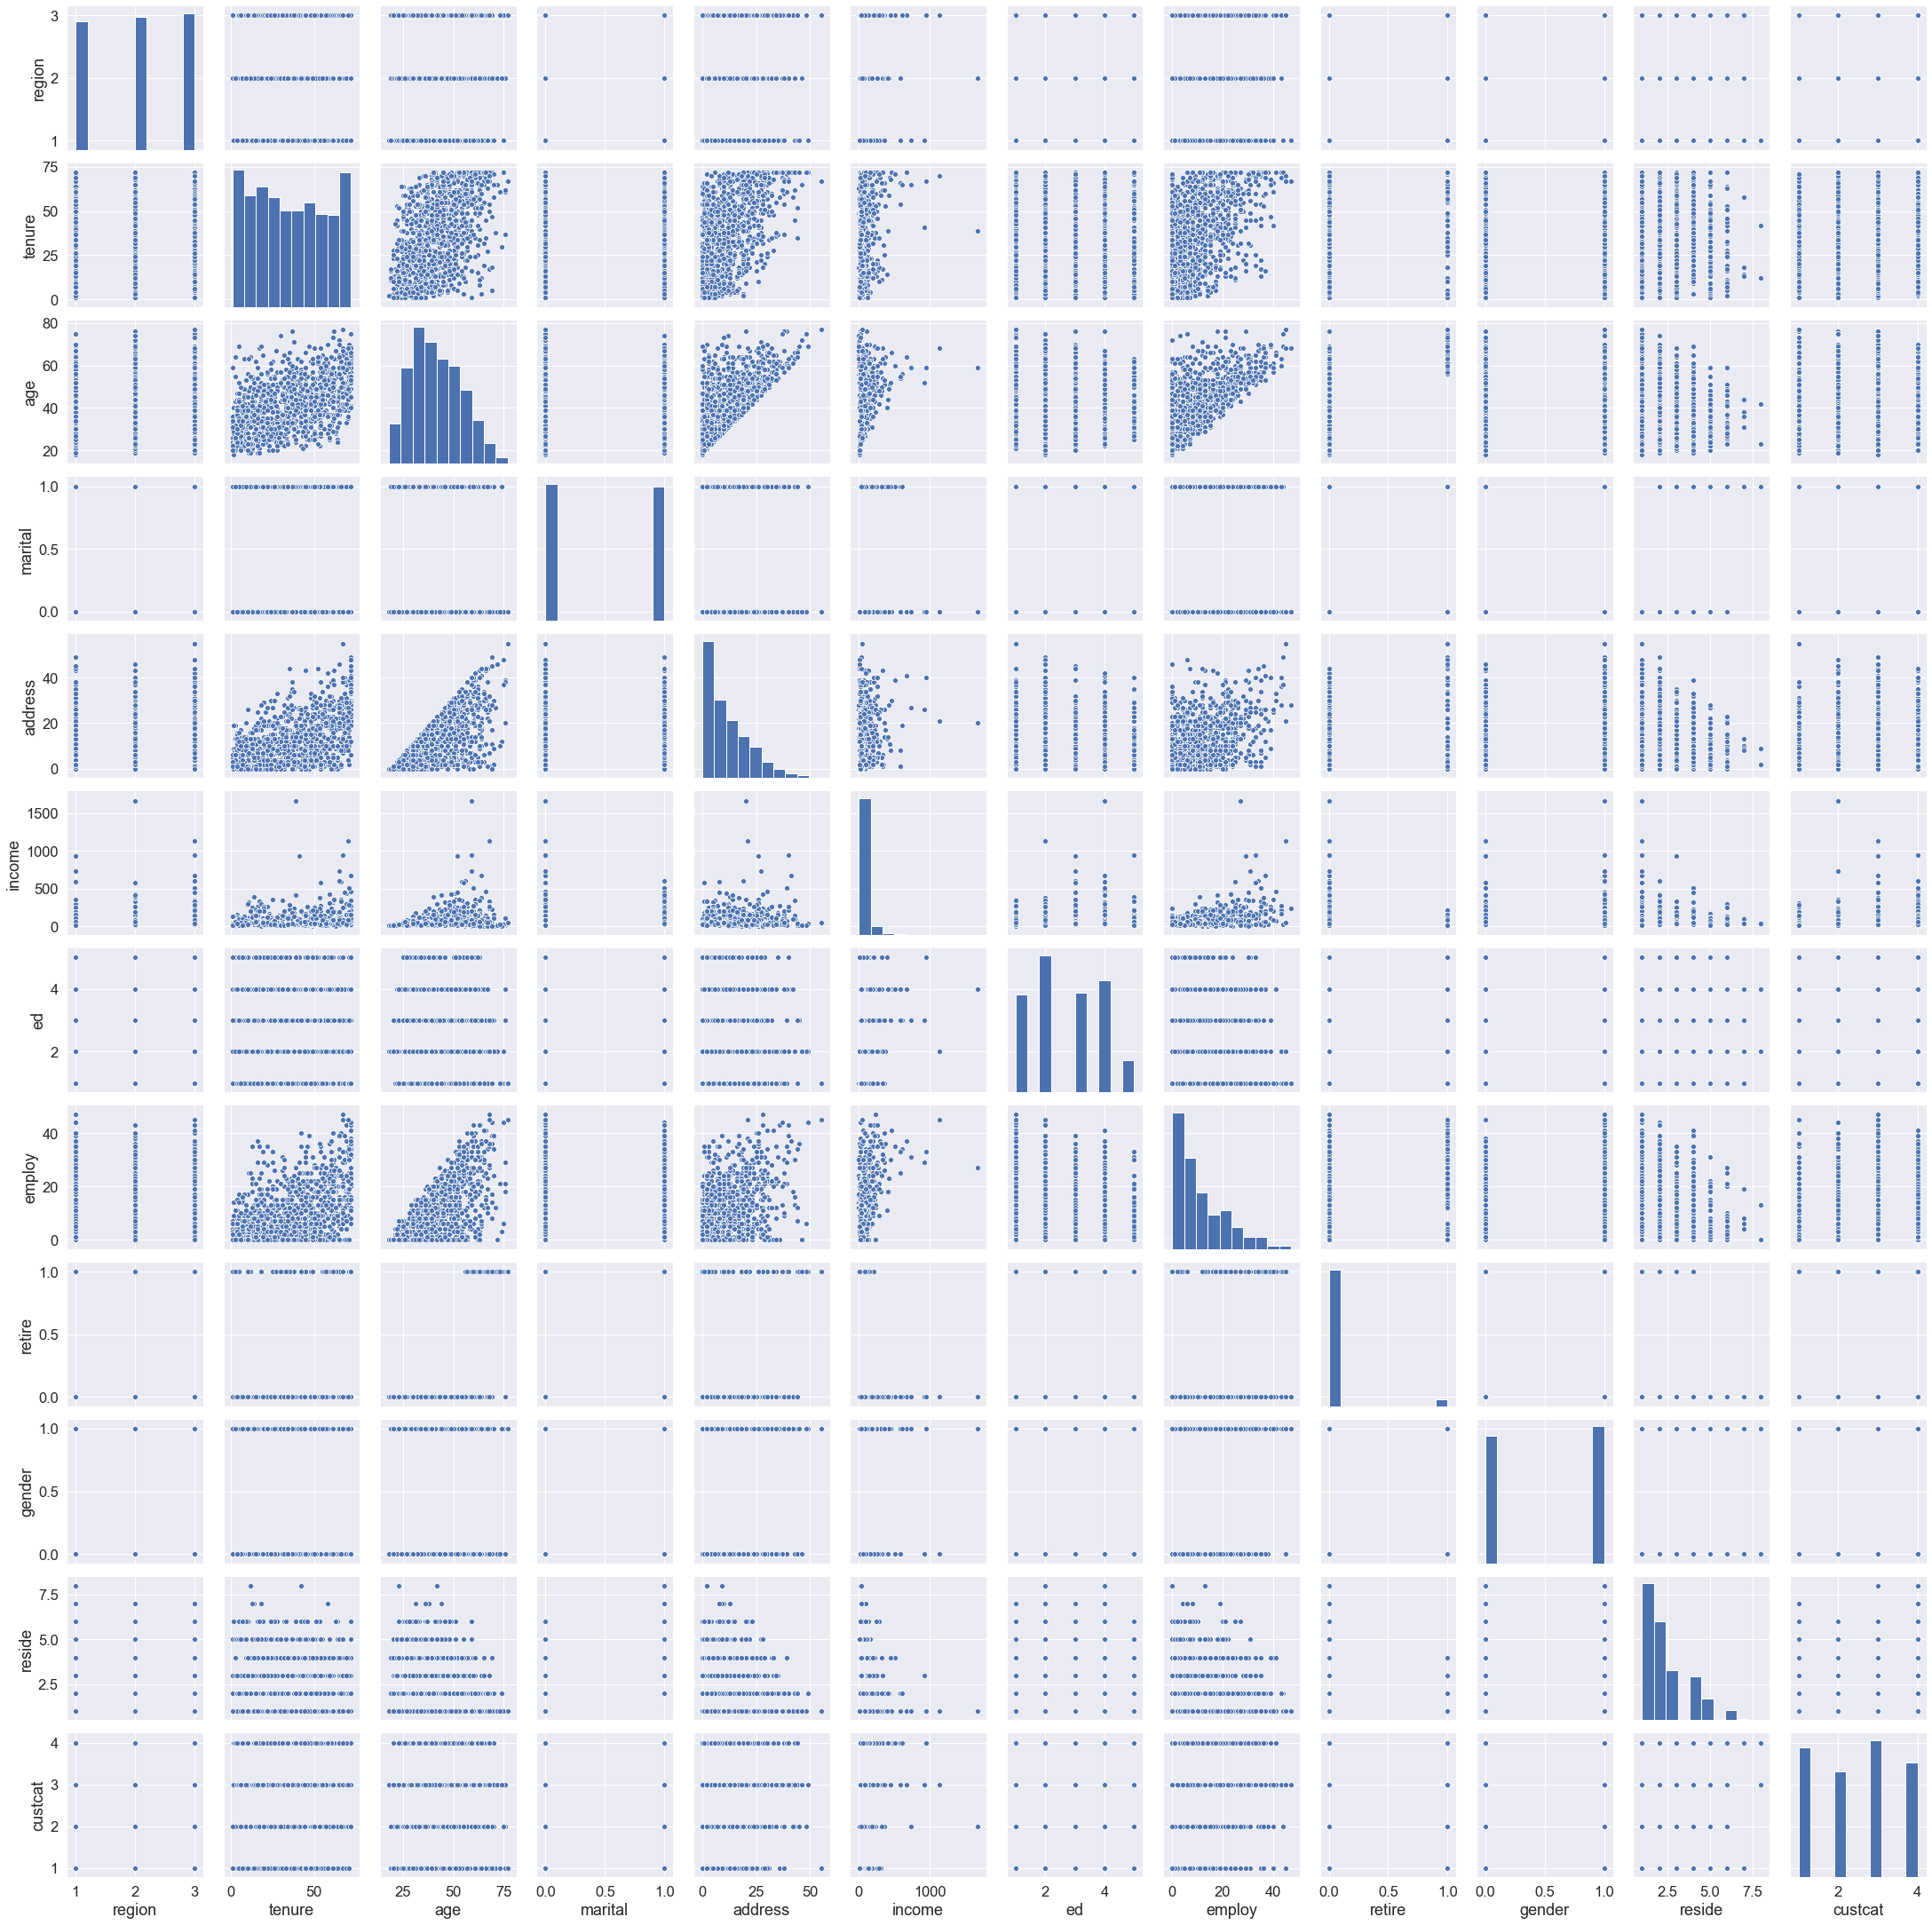

In [11]:
sns.pairplot(df, palette="husl")
plt.show()

### Data Preprocessing

### Treat Missing Values

In [12]:
df.isnull().sum()

region     0
tenure     0
age        0
marital    0
address    0
income     0
ed         0
employ     0
retire     0
gender     0
reside     0
custcat    0
dtype: int64

### Treat Duplicate Values

In [13]:
df.duplicated(keep='first').sum()

0

### Treat Outliers

### Treat Data Types

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   region   1000 non-null   int64  
 1   tenure   1000 non-null   int64  
 2   age      1000 non-null   int64  
 3   marital  1000 non-null   int64  
 4   address  1000 non-null   int64  
 5   income   1000 non-null   float64
 6   ed       1000 non-null   int64  
 7   employ   1000 non-null   int64  
 8   retire   1000 non-null   float64
 9   gender   1000 non-null   int64  
 10  reside   1000 non-null   int64  
 11  custcat  1000 non-null   int64  
dtypes: float64(2), int64(10)
memory usage: 93.9 KB


In [15]:
df.columns

Index(['region', 'tenure', 'age', 'marital', 'address', 'income', 'ed',
       'employ', 'retire', 'gender', 'reside', 'custcat'],
      dtype='object')

In [16]:
df['region'] = df['region'].astype('object')

In [17]:
df['ed'] = df['ed'].astype('object')

In [18]:
df['reside'] = df['reside'].astype('object')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   region   1000 non-null   object 
 1   tenure   1000 non-null   int64  
 2   age      1000 non-null   int64  
 3   marital  1000 non-null   int64  
 4   address  1000 non-null   int64  
 5   income   1000 non-null   float64
 6   ed       1000 non-null   object 
 7   employ   1000 non-null   int64  
 8   retire   1000 non-null   float64
 9   gender   1000 non-null   int64  
 10  reside   1000 non-null   object 
 11  custcat  1000 non-null   int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 93.9+ KB


In [20]:
df2 = pd.get_dummies(df,columns=['region','ed','reside'],drop_first=True)

In [21]:
df2

,tenure,age,marital,address,income,employ,retire,gender,custcat,region_2,region_3,ed_2,ed_3,ed_4,ed_5,reside_2,reside_3,reside_4,reside_5,reside_6,reside_7,reside_8
0,13,44,1,9,64.0,5,0.0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0
1,11,33,1,7,136.0,5,0.0,0,4,0,1,0,0,0,1,0,0,0,0,1,0,0
2,68,52,1,24,116.0,29,0.0,1,3,0,1,0,0,0,0,1,0,0,0,0,0,0
3,33,33,0,12,33.0,0,0.0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0
4,23,30,1,9,30.0,2,0.0,0,3,1,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,10,39,0,0,27.0,0,0.0,1,1,0,1,0,1,0,0,0,1,0,0,0,0,0
996,7,34,0,2,22.0,5,0.0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0
997,67,59,0,40,944.0,33,0.0,1,4,0,1,0,0,0,1,0,0,0,0,0,0,0
998,70,49,0,18,87.0,22,0.0,1,3,0,1,1,0,0,0,0,0,0,0,0,0,0


### Drop unwanted features

In [22]:
df2.columns

Index(['tenure', 'age', 'marital', 'address', 'income', 'employ', 'retire',
       'gender', 'custcat', 'region_2', 'region_3', 'ed_2', 'ed_3', 'ed_4',
       'ed_5', 'reside_2', 'reside_3', 'reside_4', 'reside_5', 'reside_6',
       'reside_7', 'reside_8'],
      dtype='object')

In [23]:
df2 = df2[['tenure', 'age', 'marital', 'address', 'income', 'employ', 'retire', 'gender',
          'region_2', 'region_3', 'ed_2', 'ed_3', 'ed_4','ed_5',
          'reside_2', 'reside_3', 'reside_4', 'reside_5', 'reside_6','reside_7', 'reside_8','custcat' ]]

In [24]:
df2

,tenure,age,marital,address,income,employ,retire,gender,region_2,region_3,ed_2,ed_3,ed_4,ed_5,reside_2,reside_3,reside_4,reside_5,reside_6,reside_7,reside_8,custcat
0,13,44,1,9,64.0,5,0.0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1
1,11,33,1,7,136.0,5,0.0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,4
2,68,52,1,24,116.0,29,0.0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,3
3,33,33,0,12,33.0,0,0.0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1
4,23,30,1,9,30.0,2,0.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,10,39,0,0,27.0,0,0.0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,1
996,7,34,0,2,22.0,5,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1
997,67,59,0,40,944.0,33,0.0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,4
998,70,49,0,18,87.0,22,0.0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,3


### Create and save processed dataset

In [25]:
#df2.to_csv("grouptrain.csv",index=False)

In [26]:
df2.shape

(1000, 22)

### Train Test Split

In [27]:
X = df2.iloc[:,0:21]
y = df2.iloc[:,21]

In [28]:
X

,tenure,age,marital,address,income,employ,retire,gender,region_2,region_3,ed_2,ed_3,ed_4,ed_5,reside_2,reside_3,reside_4,reside_5,reside_6,reside_7,reside_8
0,13,44,1,9,64.0,5,0.0,0,1,0,0,0,1,0,1,0,0,0,0,0,0
1,11,33,1,7,136.0,5,0.0,0,0,1,0,0,0,1,0,0,0,0,1,0,0
2,68,52,1,24,116.0,29,0.0,1,0,1,0,0,0,0,1,0,0,0,0,0,0
3,33,33,0,12,33.0,0,0.0,1,1,0,1,0,0,0,0,0,0,0,0,0,0
4,23,30,1,9,30.0,2,0.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,10,39,0,0,27.0,0,0.0,1,0,1,0,1,0,0,0,1,0,0,0,0,0
996,7,34,0,2,22.0,5,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
997,67,59,0,40,944.0,33,0.0,1,0,1,0,0,0,1,0,0,0,0,0,0,0
998,70,49,0,18,87.0,22,0.0,1,0,1,1,0,0,0,0,0,0,0,0,0,0


### Balance the data

In [29]:
y.value_counts()

3    281
1    266
4    236
2    217
Name: custcat, dtype: int64

In [30]:
SE = SMOTE(random_state=0)

In [31]:
X_resampled, y_resampled = SE.fit_resample(X,y)

In [32]:
X_resampled

,tenure,age,marital,address,income,employ,retire,gender,region_2,region_3,ed_2,ed_3,ed_4,ed_5,reside_2,reside_3,reside_4,reside_5,reside_6,reside_7,reside_8
0,13,44,1,9,64.000000,5,0.0,0,1,0,0,0,1,0,1,0,0,0,0,0,0
1,11,33,1,7,136.000000,5,0.0,0,0,1,0,0,0,1,0,0,0,0,1,0,0
2,68,52,1,24,116.000000,29,0.0,1,0,1,0,0,0,0,1,0,0,0,0,0,0
3,33,33,0,12,33.000000,0,0.0,1,1,0,1,0,0,0,0,0,0,0,0,0,0
4,23,30,1,9,30.000000,2,0.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119,44,49,1,2,66.279827,7,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1120,41,42,0,10,41.417109,9,0.0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
1121,59,50,1,25,238.775454,19,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1122,70,57,1,20,98.000000,27,0.0,1,1,0,0,0,0,0,1,0,0,0,0,0,0


In [33]:
y_resampled.value_counts()

4    281
3    281
2    281
1    281
Name: custcat, dtype: int64

In [34]:
X_resampled.values, y_resampled.values

(array([[13., 44.,  1., ...,  0.,  0.,  0.],
        [11., 33.,  1., ...,  1.,  0.,  0.],
        [68., 52.,  1., ...,  0.,  0.,  0.],
        ...,
        [59., 50.,  1., ...,  0.,  0.,  0.],
        [70., 57.,  1., ...,  0.,  0.,  0.],
        [70., 54.,  1., ...,  0.,  0.,  0.]]),
 array([1, 4, 3, ..., 4, 4, 4], dtype=int64))

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=0)

In [36]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((899, 21), (225, 21), (899,), (225,))

### Feature Scaling

In [37]:
X_train

,tenure,age,marital,address,income,employ,retire,gender,region_2,region_3,ed_2,ed_3,ed_4,ed_5,reside_2,reside_3,reside_4,reside_5,reside_6,reside_7,reside_8
919,50,52,1,22,162.000000,27,0.000000,1,0,0,1,0,0,0,1,0,0,0,0,0,0
492,4,37,0,2,41.000000,8,0.000000,0,0,1,1,0,0,0,0,0,0,0,0,0,0
1045,62,72,0,22,37.601866,14,0.783178,1,0,0,0,0,0,0,0,0,0,0,0,0,0
944,71,61,1,19,155.000000,30,0.000000,0,0,0,0,1,0,0,1,0,0,0,0,0,0
338,5,69,0,0,11.000000,14,1.000000,0,1,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,15,38,0,5,44.365420,3,0.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0
763,24,61,1,6,112.000000,3,0.000000,1,0,0,0,0,1,0,0,0,1,0,0,0,0
835,10,20,1,1,20.000000,0,0.000000,1,1,0,1,0,0,0,0,0,1,0,0,0,0
559,51,36,0,13,62.000000,9,0.000000,0,1,0,0,1,0,0,1,0,0,0,0,0,0


In [38]:
minmax = MinMaxScaler()

In [39]:
X_train_scaled = minmax.fit_transform(X_train)

In [40]:
X_test_scaled = minmax.transform(X_test)

In [41]:
X_train_scaled

array([[0.69014085, 0.57627119, 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.04225352, 0.3220339 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.85915493, 0.91525424, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.12676056, 0.03389831, 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.70422535, 0.30508475, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.98591549, 0.83050847, 1.        , ..., 0.        , 0.        ,
        0.        ]])

In [42]:
X_test_scaled

array([[0.73239437, 0.33898305, 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.11267606, 0.37288136, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.29577465, 0.33898305, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.25352113, 0.13559322, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.81690141, 0.61016949, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.04225352, 0.59322034, 0.        , ..., 0.        , 0.        ,
        0.        ]])

### Model Training

### Using XGBoost

In [43]:
xgbmodel = XGBClassifier(random_state=0, n_estimators=100, objective='multi:softmax')

In [44]:
xgbmodel.fit(X_train_scaled,y_train,eval_set=[(X_test_scaled,y_test)],eval_metric='merror',early_stopping_rounds=20)

[0]	validation_0-merror:0.6
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.586667
[2]	validation_0-merror:0.577778
[3]	validation_0-merror:0.564444
[4]	validation_0-merror:0.546667
[5]	validation_0-merror:0.56
[6]	validation_0-merror:0.564444
[7]	validation_0-merror:0.564444
[8]	validation_0-merror:0.555556
[9]	validation_0-merror:0.56
[10]	validation_0-merror:0.564444
[11]	validation_0-merror:0.56
[12]	validation_0-merror:0.555556
[13]	validation_0-merror:0.546667
[14]	validation_0-merror:0.546667
[15]	validation_0-merror:0.551111
[16]	validation_0-merror:0.564444
[17]	validation_0-merror:0.56
[18]	validation_0-merror:0.564444
[19]	validation_0-merror:0.577778
[20]	validation_0-merror:0.568889
[21]	validation_0-merror:0.551111
[22]	validation_0-merror:0.551111
[23]	validation_0-merror:0.546667
[24]	validation_0-merror:0.542222
[25]	validation_0-merror:0.537778
[26]	validation_0-merror:0.537778
[27]	validation_0-merror:0.546667
[28]	validat

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [45]:
y_pred = xgbmodel.predict(X_test_scaled)

In [46]:
y_pred

array([3, 1, 4, 2, 3, 1, 4, 3, 1, 2, 4, 3, 1, 2, 3, 1, 1, 1, 1, 1, 1, 3,
       2, 1, 2, 2, 3, 2, 2, 4, 3, 3, 1, 3, 2, 2, 1, 3, 2, 4, 3, 1, 1, 2,
       1, 3, 3, 1, 1, 4, 3, 3, 2, 2, 2, 1, 2, 4, 3, 3, 3, 2, 4, 1, 3, 4,
       3, 4, 4, 3, 1, 2, 1, 2, 2, 1, 3, 1, 4, 4, 2, 2, 2, 2, 2, 2, 1, 3,
       1, 4, 2, 1, 3, 4, 1, 2, 1, 1, 3, 1, 3, 3, 3, 1, 3, 1, 2, 3, 1, 3,
       1, 3, 1, 3, 1, 4, 3, 3, 4, 2, 3, 1, 2, 4, 4, 3, 3, 3, 3, 2, 3, 1,
       4, 1, 1, 1, 1, 4, 1, 4, 4, 1, 4, 4, 4, 3, 1, 3, 3, 1, 3, 4, 1, 4,
       3, 3, 4, 4, 4, 3, 2, 4, 3, 2, 2, 3, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1,
       1, 3, 4, 3, 1, 1, 2, 2, 1, 2, 3, 2, 3, 2, 1, 4, 2, 3, 2, 1, 3, 2,
       3, 4, 1, 3, 1, 4, 1, 4, 3, 1, 4, 1, 3, 3, 1, 1, 2, 4, 4, 4, 3, 3,
       3, 1, 1, 3, 1], dtype=int64)

### Model Evaluation

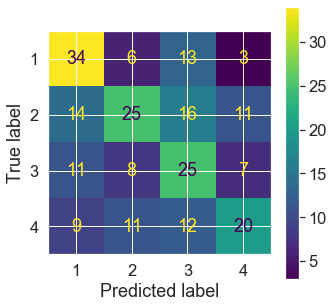

In [47]:
fig , ax = plt.subplots(figsize=(5,5))
plot_confusion_matrix(xgbmodel,X_test_scaled,y_test,values_format='.4g',ax=ax)
plt.show()

In [48]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.50      0.61      0.55        56
           2       0.50      0.38      0.43        66
           3       0.38      0.49      0.43        51
           4       0.49      0.38      0.43        52

    accuracy                           0.46       225
   macro avg       0.47      0.47      0.46       225
weighted avg       0.47      0.46      0.46       225



### Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]

In [49]:
X.columns

Index(['tenure', 'age', 'marital', 'address', 'income', 'employ', 'retire',
       'gender', 'region_2', 'region_3', 'ed_2', 'ed_3', 'ed_4', 'ed_5',
       'reside_2', 'reside_3', 'reside_4', 'reside_5', 'reside_6', 'reside_7',
       'reside_8'],
      dtype='object')

In [50]:
xgbmodel.get_booster().feature_names = ['tenure', 'age', 'marital', 'address', 'income', 'employ', 'retire',
       'gender', 'region_2', 'region_3', 'ed_2', 'ed_3', 'ed_4', 'ed_5',
       'reside_2', 'reside_3', 'reside_4', 'reside_5', 'reside_6', 'reside_7',
       'reside_8']

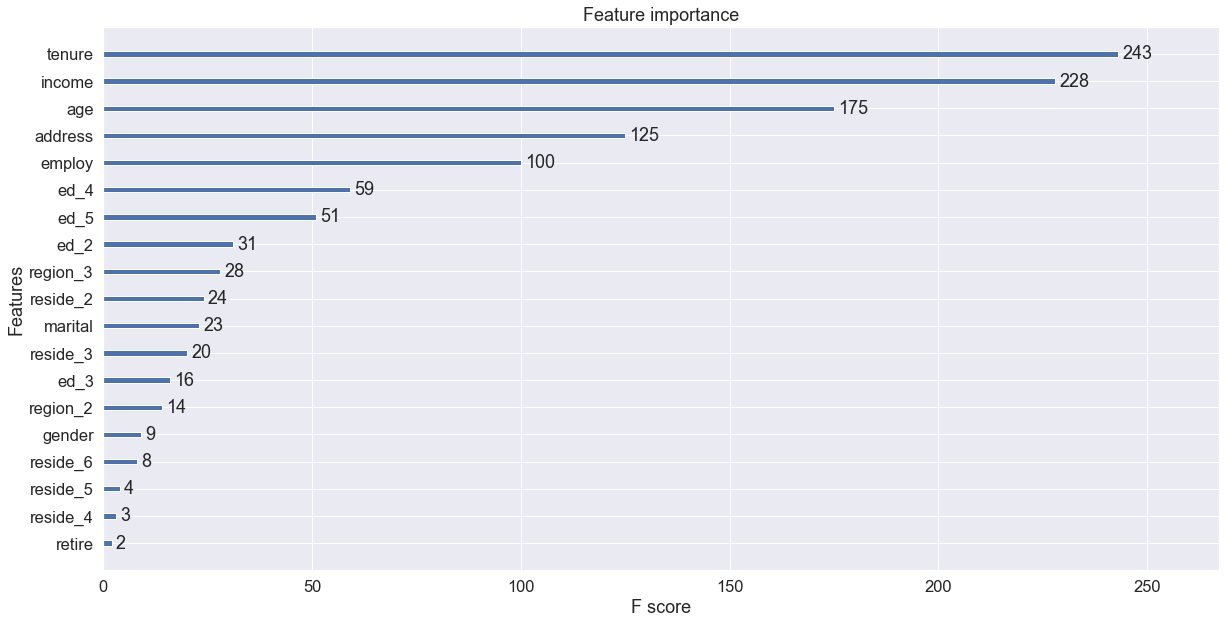

In [51]:
fig, ax = plt.subplots(figsize=(20,10))
xgb.plot_importance(xgbmodel.get_booster(),ax=ax)
plt.show()

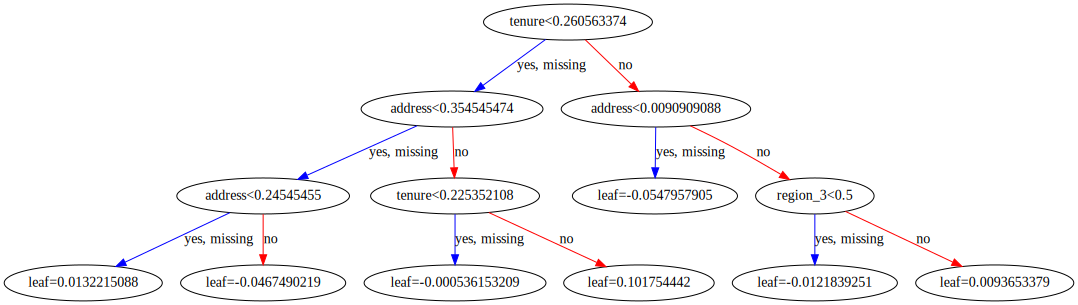

In [52]:
xgb.to_graphviz(xgbmodel,num_trees=100)

### Cross-Validation

In [53]:
cv = cross_val_score(xgbmodel,X_resampled,y_resampled,cv=5,verbose=1,scoring='accuracy')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s finished


In [54]:
cv.mean()

0.37903571428571425

### Feature Selection

### Model Prediction

### Model Tuning

### Using RandomSearchCV

In [55]:
model = XGBClassifier(random_state=0, n_estimators=100, objective='multi:softmax')

In [56]:
parameters = {'max_depth': np.arange(3,10,1),
              'learning rate': np.arange(0.05,0.3,0.03),
              'n_estimators':np.arange(100,1000,100),
              'min_child_weight': np.arange(1,4,1),
              'gamma':np.arange(0,50,2),
              'subsample':np.arange(0.5,0.9,0.1),
              'colsample_bytree':np.arange(0.5,0.9,0.1)
             }

In [57]:
randm = RandomizedSearchCV(estimator=model, param_distributions = parameters, cv = 5, n_iter = 50, 
                           n_jobs=-1, scoring='accuracy')

In [58]:
randm.fit(X_resampled, y_resampled)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='multi:softmax',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scal...
       34, 36, 38, 40, 42, 44, 46, 48]),
                                        'learning rate': array([0.05, 0.08, 0.11, 0.14, 0.17, 0.2 , 0.23, 0.26, 0.29]),
                

In [59]:
randm.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=4,
              learning rate=0.26, learning_rate=0.1, max_delta_step=0,
              max_depth=8, min_child_weight=2, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.6, verbosity=1)

In [60]:
randm.best_score_

0.40217063492063493

In [61]:
randm.best_params_

{'subsample': 0.6,
 'n_estimators': 100,
 'min_child_weight': 2,
 'max_depth': 8,
 'learning rate': 0.26,
 'gamma': 4,
 'colsample_bytree': 0.7}

### Using GridSearchCV

### Final Model

In [62]:
xgbnew = XGBClassifier(colsample_bylevel=1,colsample_bynode=1, colsample_bytree=0.7999999999999999, gamma=4,
              learning_rate=0.2, max_delta_step=0,max_depth=9, min_child_weight=2, missing=None, n_estimators=300,
              n_jobs=1, nthread=None, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.7999999999999999,
              verbosity=1)

In [63]:
xgbnew.fit(X_train_scaled,y_train,eval_set=[(X_test_scaled,y_test)],eval_metric='merror',early_stopping_rounds=20)

[0]	validation_0-merror:0.56
Will train until validation_0-merror hasn't improved in 20 rounds.
[1]	validation_0-merror:0.546667
[2]	validation_0-merror:0.56
[3]	validation_0-merror:0.568889
[4]	validation_0-merror:0.546667
[5]	validation_0-merror:0.568889
[6]	validation_0-merror:0.528889
[7]	validation_0-merror:0.546667
[8]	validation_0-merror:0.542222
[9]	validation_0-merror:0.533333
[10]	validation_0-merror:0.533333
[11]	validation_0-merror:0.511111
[12]	validation_0-merror:0.511111
[13]	validation_0-merror:0.502222
[14]	validation_0-merror:0.502222
[15]	validation_0-merror:0.52
[16]	validation_0-merror:0.506667
[17]	validation_0-merror:0.506667
[18]	validation_0-merror:0.497778
[19]	validation_0-merror:0.511111
[20]	validation_0-merror:0.502222
[21]	validation_0-merror:0.511111
[22]	validation_0-merror:0.511111
[23]	validation_0-merror:0.515556
[24]	validation_0-merror:0.493333
[25]	validation_0-merror:0.506667
[26]	validation_0-merror:0.506667
[27]	validation_0-merror:0.52
[28]	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7999999999999999, gamma=4,
              learning_rate=0.2, max_delta_step=0, max_depth=9,
              min_child_weight=2, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7999999999999999, verbosity=1)

In [64]:
y_pred = xgbnew.predict(X_test_scaled)

In [65]:
y_pred

array([2, 1, 4, 2, 3, 1, 4, 3, 1, 2, 4, 4, 1, 4, 3, 1, 1, 1, 1, 1, 1, 3,
       4, 1, 2, 2, 1, 3, 2, 4, 3, 3, 1, 3, 4, 2, 1, 3, 2, 4, 3, 1, 1, 2,
       1, 3, 4, 1, 1, 4, 3, 3, 2, 3, 4, 1, 4, 4, 2, 3, 3, 2, 2, 3, 4, 4,
       1, 1, 4, 3, 4, 2, 2, 2, 4, 4, 3, 1, 4, 4, 3, 2, 2, 2, 2, 2, 1, 3,
       1, 4, 2, 1, 3, 2, 1, 2, 3, 2, 2, 1, 4, 3, 3, 3, 3, 1, 3, 3, 1, 3,
       4, 3, 1, 3, 1, 4, 3, 3, 4, 2, 3, 1, 2, 4, 4, 1, 1, 3, 3, 2, 3, 1,
       4, 1, 1, 1, 3, 4, 1, 4, 4, 1, 4, 4, 4, 3, 4, 4, 3, 1, 3, 4, 1, 4,
       3, 3, 4, 4, 4, 1, 3, 4, 3, 2, 2, 2, 2, 2, 1, 4, 1, 2, 1, 4, 2, 4,
       1, 3, 4, 3, 3, 1, 2, 4, 1, 3, 3, 3, 3, 2, 1, 1, 4, 2, 2, 1, 3, 2,
       3, 4, 1, 3, 1, 2, 1, 2, 3, 1, 4, 1, 3, 3, 1, 1, 2, 4, 3, 4, 3, 3,
       1, 1, 4, 2, 1], dtype=int64)

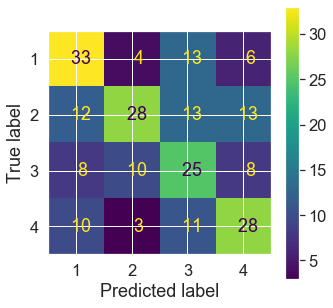

In [66]:
fig , ax = plt.subplots(figsize=(5,5))
plot_confusion_matrix(xgbnew,X_test_scaled,y_test,values_format='4g',ax=ax)
plt.show()

In [67]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.52      0.59      0.55        56
           2       0.62      0.42      0.50        66
           3       0.40      0.49      0.44        51
           4       0.51      0.54      0.52        52

    accuracy                           0.51       225
   macro avg       0.51      0.51      0.51       225
weighted avg       0.52      0.51      0.51       225



### Save the Model

In [68]:
filename = 'modelgroup.sav'
dump(xgbnew,open(filename,'wb'))